## STML

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cec2017.functions import *
import pandas as pd
import time

%matplotlib inline

In [2]:
def boundery_checker(pop, min_val, max_val):
    adj_pop = np.where(pop<min_val, min_val, pop)
    adj_pop = np.where(adj_pop>max_val, max_val, adj_pop)
    return adj_pop

def init_genrator_tlbo(min_val, max_val, num_variables, pop_size):
    return np.random.uniform(min_val, max_val, (pop_size, num_variables))

def sorting_pop(pop, obj_func):
    results = obj_func(pop)
    indeces = np.argsort(results)
    return pop[indeces]

def teacher_phase(pop, pop_size, obj_func, min_val, max_val):
    teacher = pop[0]
    center = np.mean(pop, axis=0)
    rand = np.random.uniform(0,1,size=(pop_size,1))
    teacher_factor = np.random.choice(np.arange(1,3), size=(pop_size,1))
    diff = rand*(teacher-center*teacher_factor)
    pop_new = pop + diff
    pop_new = boundery_checker(pop_new, min_val, max_val)
    results = obj_func(pop)
    results_new = obj_func(pop_new)
    return np.where((results_new<results).reshape(-1,1), pop_new, pop)

def learner_phase(pop, pop_size, obj_func, min_val, max_val):
    rand = np.random.uniform(0,1,size=(pop_size,1))
    pop_new = np.zeros_like(pop)
    for i in range(pop_size):
        x, y = np.sort(np.random.choice(np.arange(pop_size), size=2, replace=False))
        pop_new[i] = pop[i] + rand[i]*(pop[x]-pop[y])
    pop_new = boundery_checker(pop_new, min_val, max_val)
    pop_overall = np.concatenate((pop, pop_new), axis=0)
    pop_overall = sorting_pop(pop_overall, obj_func)
    return pop_overall[:pop_size]

def tlbo(pop_size, iteration, min_val, max_val, num_variables, obj_func):
    NFE_value = 0
    pop = init_genrator_tlbo(min_val, max_val, num_variables, pop_size)
    pop = sorting_pop(pop, obj_func)
    for i in range(iteration):
        pop = teacher_phase(pop, pop_size, obj_func, min_val, max_val)
        pop = sorting_pop(pop, obj_func)
        pop = learner_phase(pop, pop_size, obj_func, min_val, max_val)
        NFE_value += (3*pop_size)
    return pop[0], obj_func([pop[0]]), NFE_value

def init_generator(pop_size_min, pop_size_max, iteration_min, iteration_max):
    return np.random.uniform(np.array([pop_size_min,iteration_min]),np.array([pop_size_max,iteration_max]),size=2).astype(int)

def exploratory_move(X, mu, NFE_value, min_val, max_val, num_variables, obj_func):
    mesh = (mu*np.eye(len(X)) + X).astype(int)
    sim_results = np.zeros(shape=(len(mesh), num_variables))
    eval_results = np.zeros(len(mesh))
    for index in range(len(mesh)):
        array, of_best, NFE = tlbo(mesh[index][0], mesh[index][1], min_val, max_val, num_variables, obj_func)
        sim_results[index] = array
        eval_results[index] = of_best
        NFE_value += NFE
    return mesh, eval_results, sim_results, NFE_value  

def pattern_move(current_base, previous_base, NFE_value, min_val, max_val, num_variables, obj_func, alpha,
                 pop_size_min, pop_size_max, iteration_min, iteration_max):
    current_base, previous_base = np.array(current_base), np.array(previous_base) #????
    X_new = previous_base + alpha*(current_base-previous_base)
    sim_result, of_new, NFE = tlbo(X_new[0], X_new[1], min_val, max_val, num_variables, obj_func)
    NFE_value += NFE
    return X_new.astype(int), sim_result, of_new, NFE_value

def mega_algorithem(obj_func, min_val, max_val, num_variables, 
                    pop_size_min=10, pop_size_max=50, iteration_min=20, iteration_max=500,
                    mu_const=5, alpha=2, delta=1, final_step_size=1):
    num_s_patt = 0
    num_s_explore = 0
    results_list = list()
    NFE_list = list()
    hypr_list = list()
    NFE_value = 0
    X = init_generator(pop_size_min, pop_size_max, iteration_min, iteration_max)
    setting, best_of, NFE = tlbo(X[0], X[1], min_val, max_val, num_variables, obj_func)
    NFE_value += NFE
    mu = mu_const
    hypr_list.append(X)
    results_list.append(best_of[0])
    NFE_list.append(NFE_value)
    while mu > final_step_size:
        mesh, eval_results, new_settings, NFE_value = exploratory_move(X, mu, NFE_value, min_val, max_val,
                                                                       num_variables, obj_func)
        if np.min(eval_results) < best_of:
            num_s_explore += 1
            mu = mu_const
            best_of = np.array([np.min(eval_results)])
            current_base = mesh[np.argmin(eval_results)]
            previous_base = X
            setting = new_settings[np.argmin(eval_results)]
            hypr_list.append(current_base)
            results_list.append(best_of[0])
            NFE_list.append(NFE_value)
            while True:
                X_new, sim_result, of_new, NFE_value = pattern_move(current_base, previous_base, NFE_value,min_val,
                                                                    max_val, num_variables, obj_func, alpha,
                                                                    pop_size_min, pop_size_max, iteration_min,
                                                                    iteration_max)
                if of_new < best_of:
                    num_s_patt += 1
                    previous_base = current_base
                    current_base, best_of = X_new, of_new
                    setting = sim_result
                    hypr_list.append(current_base)
                    results_list.append(best_of[0])
                    NFE_list.append(NFE_value)
                    mesh, eval_results, new_settings, NFE_value = exploratory_move(current_base, mu, NFE_value, min_val,
                                                                                   max_val, num_variables, obj_func)
                    if np.min(eval_results) < best_of:
                        num_s_explore += 1
                        best_of = np.array([np.min(eval_results)])
                        previous_base = current_base
                        current_base = mesh[np.argmin(eval_results)]
                        setting = new_settings[np.argmin(eval_results)]
                        hypr_list.append(current_base)
                        results_list.append(best_of[0])
                        NFE_list.append(NFE_value)
                else:
                    mu -= delta
                    X = current_base
                    hypr_list.append(current_base)
                    results_list.append(best_of[0])
                    NFE_list.append(NFE_value)
                    break
        else:
            mu -= delta
            hypr_list.append(X)
            results_list.append(best_of[0])
            NFE_list.append(NFE_value)
    return setting, best_of, results_list, NFE_list, X, hypr_list, (num_s_explore, num_s_patt)

# Benchmarks

There are over 30 functions here in this suit. We have to test all of them. 

* From what Ramiz told me `num_variables` should be **{2, 10, 20, 30, 50, 100}**; We have come to the conclusion that for now, perhaps it is best to stick with only 10; Depending on the runtime, we may be able to expand this a bit further. 

* Make sure that you manually change the `func_name` as this would be saved later on in the files. 

In [3]:
obj_func = f3
func_name = 'f9'
alg_name = 'STML'
num_variables = 10
min_val, max_val = -100, 100

pop_size_min, pop_size_max = 100, 200
iteration_min, iteration_max = 500, 750

**PARAMETER TUNING**

This part I added just to make sure that you can do some prameter tuning, after the parameters are set and you are comfortable you can move on to the next phase with the set parameters. 

**HINT**: I sperated the *algorithm's parameters* from the rest of the model variables so that you know what you should play with. 

In [4]:
start_time = time.time()
X, best_of, results_list, NFE_list, setting, setting_list, nums = mega_algorithem(obj_func, min_val, max_val,
                                                                                  num_variables, pop_size_min,
                                                                                  pop_size_max, iteration_min,
                                                                                  iteration_max)
end_time = time.time()
minute = (end_time-start_time)//60
second = (end_time-start_time)-60*minute
print('Best OF', '='*20)
print(best_of)
print('Variables', '='*18)
print(X)
print('second layer parametr', '='*18)
print(setting)
print('Number of successful Exploratory & Pattern moves')
print('Exploratory: %d; Pattren: %d'%nums)
print('Time', '='*22)
print('Time: %d min and %.2f s'%(minute, second))

Best OF ====================
[300.]
Variables ==================
[-55.93832662   4.54306541  35.30007021   8.27944086 -47.43694278
   7.30209959   6.38766595  -2.49783142 -61.05355707 -47.13399635]
second layer parametr ==================
[103 502]
Number of successful Exploratory & Pattern moves
Exploratory: 0; Pattren: 0
Time ======================
Time: 0 min and 11.05 s


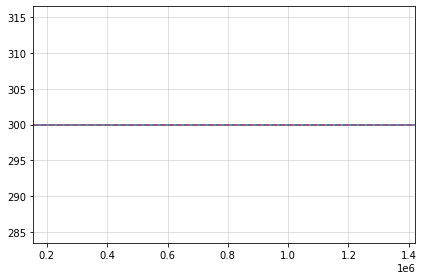

In [5]:
fig = plt.plot(NFE_list, results_list)
fig = plt.grid(alpha=.5)
fig = plt.margins(0,.05)
fig = plt.axhline(best_of,ls='--',alpha=.5,c='r')

plt.tight_layout()

In [69]:
results_list

[1736.0816379103717,
 1151.6441992066068,
 1080.1473855450708,
 942.3022812354686,
 942.3022812354686,
 942.3022812354686,
 942.3022812354686,
 942.3022812354686]

In [70]:
setting_list

[array([13, 99]),
 array([18, 99]),
 array([23, 99]),
 array([28, 99]),
 array([28, 99]),
 array([28, 99]),
 array([28, 99]),
 array([28, 99])]

In [71]:
NFE_list

[3861, 13263, 20094, 35586, 45387, 63543, 81318, 98712]

**INDEPENDENT RUNS**

`num_runs` should be around **50**, but what you can do alternatively is breaking down the task to smaller ones by doing smaller number of runs and saving and storing the files; After a manual evaluation we can detemrine how many of these are not accaptable and we should do a re-run.

In [7]:
num_runs = 80

overall_result = pd.DataFrame(columns=['Function', 'Algorithm', 'best_OF', 'NFE', 'time (s)',
                                       'Parameters', 'Best DVs', '#Succ Explr+Patrr moves'])
for i in range(num_runs):
    print('Counter: %d'%(i+1))
    start_time = time.time()
    X, best_of, results_list, NFE_list, setting, setting_list, nums = mega_algorithem(obj_func, min_val, max_val,
                                                                                      num_variables, pop_size_min,
                                                                                      pop_size_max, iteration_min,
                                                                                      iteration_max)
    end_time = time.time()
    overall_result = overall_result.append({'Function':func_name, 'Algorithm':alg_name, 
                                            'best_OF':best_of,'NFE':NFE_list[0],
                                            'time (s)':end_time-start_time,
                                            'Parameters':{'pop_size':setting[0],'iteration': setting[1]},
                                            'Best DVs': X, '#Succ Explr+Patrr moves': nums},
                                           ignore_index=True)
overall_result.to_csv(alg_name+'_'+func_name+'_result.csv')

Counter: 1
Counter: 2


**ANALYSE THE DATAFRAME**

In [21]:
#ADD STAT TEST!
#AFTER THIS WE NEED TO MAKE IT READ THE FINAL CSV FILE AND ANALSYE; NOT NOW!!!!

summary_report = pd.DataFrame(columns=['Best outcome', 'Worst outcome', 'Avr. of outcomes',
                                       'Median of outcomes', 'Std of outcome', 'Avr. runtime (s)',
                                       'Fastest runtime (s)', 'Slowest runtime (s)', 'Avr. NFE'])
bst_out = overall_result['best_OF'].min()
wrst_out = overall_result['best_OF'].max()
avr_out = overall_result['best_OF'].mean()
median_out = overall_result['best_OF'].median()
std_out = overall_result['best_OF'].std()
avr_time = overall_result['time (s)'].mean()
fst_time = overall_result['time (s)'].min()
slwst_time = overall_result['time (s)'].max()
avr_NFE = overall_result['NFE'].mean()

summary_report = summary_report.append({'Best outcome':bst_out, 'Worst outcome':wrst_out,
                                        'Avr. of outcomes':avr_out, 'Median of outcomes':median_out,
                                        'Std of outcome':std_out, 'Avr. runtime (s)':avr_time,
                                        'Fastest runtime (s)':fst_time, 'Slowest runtime (s)':slwst_time,
                                        'Avr. NFE':avr_NFE}, ignore_index=True)

summary_report.to_csv(alg_name+'_'+func_name+'_summary_report.csv')

In [22]:
summary_report

,Avr. of outcomes,Slowest runtime (s),Best outcome,Median of outcomes,Std of outcome,Fastest runtime (s),Avr. runtime (s),Avr. NFE,Worst outcome
0,2578.197574,2.39129,300.000002,304.833635,3801.992696,0.184492,1.142213,17248.2,10194.146099
